Amogus

In [1]:
import numpy as np
import matplotlib.pyplot as plt

pi = np.pi

In [69]:
a = 2
G = np.array([0,0,0])
H = np.array([0,0,2*pi/a])
P = np.array([pi/a,pi/a,pi/a])
N = np.array([0, pi/a,pi/a])

In [74]:
n_points = 50

def linspace3D(A, B, num_points = n_points):
    A = np.array(A)
    B = np.array(B)
    return [(A + (B - A) * t) for t in np.linspace(0, 1, num_points)]

def energia_bcc(k,n):
    cte = n*(pi*4/a) # Vectores convencionales de la red recíproca
    En = (k[0] + cte)**2 + (k[1] + cte)**2 + (k[2] + cte)**2
    return En

def energias(ks, n):
    energias = np.zeros(n_points)
    for i in range(n_points):
        energias[i] = energia_bcc(ks[i], n)
    return energias

def map(arr, new_min, new_max):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr)) * (new_max - new_min) + new_min

In [88]:
ksGH = linspace3D(G, P)
ksHP = linspace3D(P, H)
ksPN = linspace3D(H, N)

distsGH = map([np.linalg.norm(ksGH[i]) for i in range(n_points)], 0, 1)
distsHP = np.flip(map([np.linalg.norm(ksHP[i]) for i in range(n_points)],1,2))
distsPN = np.flip(map([np.linalg.norm(ksPN[i]) for i in range(n_points)],2,3))

trayectoria = np.concatenate((distsGH, distsHP, distsPN))
bandas = [np.concatenate((energias(ksGH,i),energias(ksHP,i), energias(ksPN,i))) for i in range(3)]

print(len(trayectoria))
print(len(bandas[0]))

150
150


ValueError: x and y must have same first dimension, but have shapes (50,) and (150,)

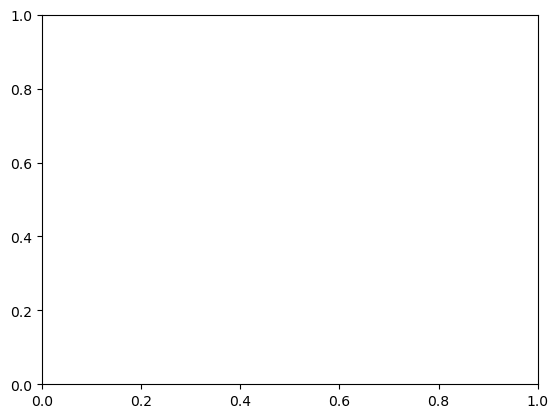

In [89]:
trayectoria = np.linspace(0,150)
plt.plot(trayectoria, bandas[0])
plt.show()

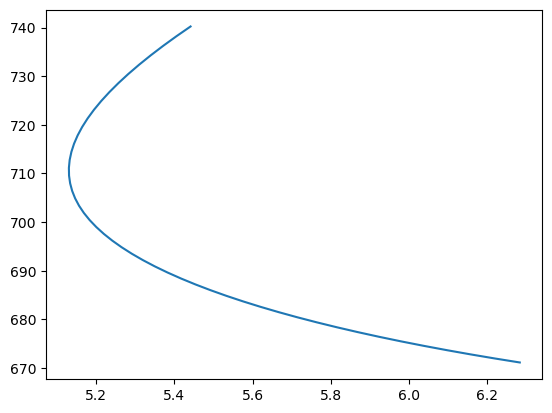

In [54]:
distsHP = [np.linalg.norm(ksHP[i]) for i in range(n_points)]
plt.plot(distsHP, energias(ksHP, 1))
plt.show()